# Global and Local Explanation for XGBoost model on PTB data


In [1]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install tensorflow -q
    !pip install keras -q
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install matplotlib -q
    !pip install umap-learn -q
    !pip install lightgbm
    !pip install xgboost

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'

Path = dict({
    'ptbdb_normal': data_path ,
    'ptbdb_abnormal':  data_path,
})

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [2]:
# Verify installation and import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline

import pickle
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import XGBModel, Booster
import os

import shap
import lime
import lime.lime_tabular


In [3]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df

def convertColumnAsInt(df, column):
    """
    As the category value is in float type. We want to get the int to identify the category.
    """
    df[column] = df[column].astype(int)
    return df

def getBarChartFromCategoryValueCounts(category_value_counts):
    """
    We call the plot over the pandas series object to plot the category count values
    """
    plt.figure(figsize=(10, 6))
    bar_chart = category_value_counts.plot(kind='bar')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(False)
    plt.xticks(rotation=360)
    for i in bar_chart.containers:
        bar_chart.bar_label(i, label_type='edge')
    plt.show()


def showTop10DataInChart(df):
    plt.figure(figsize=(10, 6))
    xDataAxis = list(range(0, df.shape[1]))
    yDataRows = list(df.values[1: 10])
    for y in yDataRows:
        plt.plot(xDataAxis, y)
    plt.show()

In [4]:
# Load
ptbdb_train = pd.read_csv('../data/processed/ptb_train_clean_default.csv')
ptbdb_test = pd.read_csv('../data/processed/ptb_test_clean_default.csv')

# Remove Dublicates
ptbdb_train = ptbdb_train.drop_duplicates()
ptbdb_test = ptbdb_test.drop_duplicates()

# Split data into features and target
X_train = ptbdb_train.drop(columns=['target'])
y_train = ptbdb_train['target']
X_test = ptbdb_test.drop(columns=['target'])
y_test = ptbdb_test['target']

# Define the model path
current_dir = os.getcwd()
model_path = os.path.join(current_dir, '..', 'models', 'model_ptb_XGBoost.pkl')



load models

In [5]:
# Load the XGBoost model (wrapped inside a pipeline)
model_path = r'..\models\model_ptb_XGBoost.pkl'  
with open(model_path, 'rb') as file:
    pipeline_model = pickle.load(file)

# Check the type of the model (pipeline)
print(f"Model type: {type(pipeline_model)}")


Model type: <class 'sklearn.pipeline.Pipeline'>


In [6]:
# Look at the steps of the pipeline
print("Pipeline steps:", pipeline_model.named_steps)
    
# Extract the XGBoost model from the pipeline
xgb_model = pipeline_model.named_steps['xgb']  # Adjust based on the name of the XGBoost step in the pipeline

Pipeline steps: {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)}


### In the following we apply explanation strategies (Feature Importance, SHAP, LIME) on the raw PTB dataset to explain the most important features within the XGBoost model due to to given strategies:


## Feature Importance

C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_2068\3488736032.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


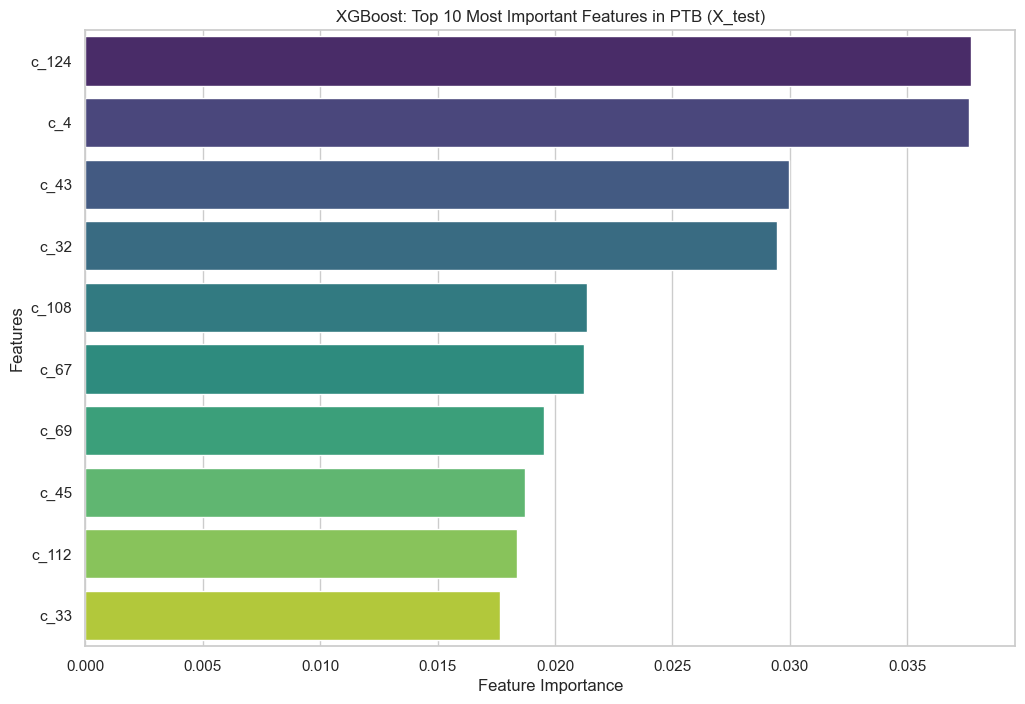

In [107]:
# Get the feature importance values
feature_importance = xgb_model.feature_importances_

# Get the feature names
feature_names = X_test.columns

# Create a DataFrame with feature names and their importance values

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Sort the DataFrame based on feature importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the top 10 most important features
top_10_features = feature_importance_df.head(10)
top_10_features

# Display the top 10 least important features
least_10_features = feature_importance_df.tail(10)
least_10_features

# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=top_10_features, 
    palette='viridis'
)
plt.title('XGBoost: Top 10 Most Important Features in PTB (X_test)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

### Interpretation:
Feature Importance Scores:

Feature importance here is measured by the impact each feature has on the model's performance. In XGBoost, this is typically calculated based on the feature's contribution to reducing error in the model's predictions (like gain or mean decrease in accuracy).
Higher values on the x-axis indicate that a feature has a more significant impact on the model's decisions.


Top Features:

The top two features, c_124 and c_4, have the highest importance values, suggesting they are the most influential in determining the model's predictions on the PTB dataset. This means, according to the Feature Importance, the 124th and 4th Frequency are most impactful to determine, weather a heartbeat is considered as Normal or Abnormal by the XGBoost model.

The rest of the features (c_43, c_32, etc.) follow in descending order of importance. While they are still valuable to the model, their impact is less compared to the top two features.

## SHAP

Top 10 most important features based on SHAP values:
    feature  importance
4      c_4    1.089543
32    c_32    0.987083
2      c_2    0.882311
1      c_1    0.841189
7      c_7    0.744983
29    c_29    0.642179
31    c_31    0.558136
3      c_3    0.512959
33    c_33    0.482629
34    c_34    0.443673


C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_2068\3509995902.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


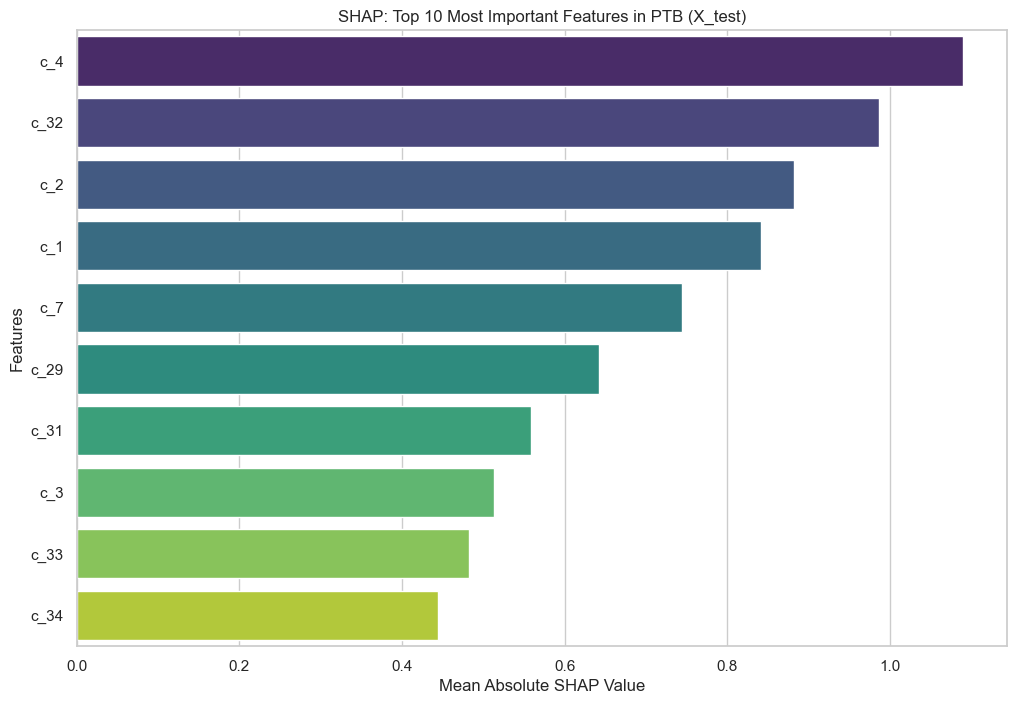

In [108]:
# Calculate the mean absolute SHAP values for each feature
shap_values_array = shap_values.values
mean_shap_values = np.abs(shap_values_array).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_shap_values
})

# Sort the DataFrame based on feature importance
shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)

# Display the top 10 most important features based on SHAP values
top_10_shap_features = shap_importance_df.head(10)
print("Top 10 most important features based on SHAP values:\n", top_10_shap_features)

# Plot the top 10 most important features based on SHAP values
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=top_10_shap_features, 
    palette='viridis'
)
plt.title('SHAP: Top 10 Most Important Features in PTB (X_test)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()

 96%|=================== | 2796/2910 [00:18<00:00]       

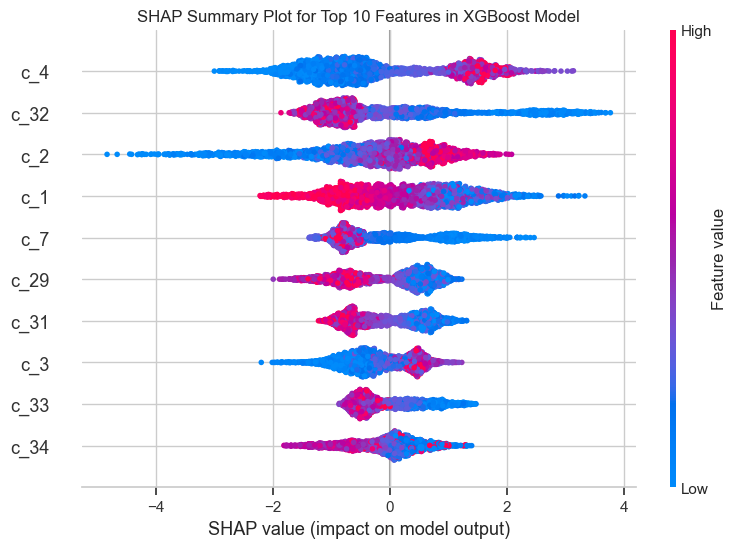

In [109]:
# Generate SHAP values for the entire X_test dataset using TreeExplainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Get the top 10 feature names based on importance from the SHAP DataFrame
top_10_feature_names = top_10_shap_features['feature'].values

# Find the indices of the top 10 features in the original dataset
top_10_feature_indices = [X_test.columns.get_loc(feature) for feature in top_10_feature_names]

# Subset the X_test data to only include the top 10 features
X_test_top_10 = X_test[top_10_feature_names]

# Subset the SHAP values for the top 10 features
shap_values_top_10 = shap_values[:, top_10_feature_indices]

# Plot the SHAP summary plot for the top 10 features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_top_10, X_test_top_10, show=False)  # Use `show=False` to modify plot before displaying
plt.title('SHAP Summary Plot for Top 10 Features in XGBoost Model')
plt.show()


### Interpretation:
SHAP Importance:
The x-axis of the plot shows the Mean Absolute SHAP Value, which represents the average magnitude of each feature's contribution to the predictions, irrespective of direction (positive or negative). Higher SHAP values indicate a more significant impact of that feature on the model's predictions.

Feature Ranking:
The y-axis lists features (e.g., c_4, c_32, c_2) in descending order of their SHAP importance values. Here, c_4 has the highest mean absolute SHAP value, indicating it is the most influential feature in the model for the PTB dataset.

Comparison to Feature Importance Plot:
While the XGBoost feature importance plot ranks features based on their contribution to error reduction, SHAP values provide a more direct interpretation of feature influence on individual predictions. This often aligns with, but may differ slightly from, traditional feature importance scores. For example, c_4 is a top feature in both XGBoost and SHAP-based plots, reinforcing its strong influence on the model. However, features like c_1 appear highly ranked in the SHAP importance plot but may not be as prominent in the XGBoost importance plot, indicating subtle differences in how each feature interacts within the model.

Interpretation of Patterns:
Each feature’s SHAP values reveal nuanced behavior:

Feature c_4: High values of c_4 (in red) significantly increase the model output, suggesting that it is a strong positive predictor. Conversely, low values (in blue) reduce the prediction.
Feature c_1: The influence of c_1 appears balanced, with both high and low values contributing positively and negatively, indicating a more complex behavior that impacts predictions in multiple ways.
Features like c_7 and c_31: These features exhibit narrower distributions, suggesting that they have a smaller or more context-specific influence on the prediction.

Conclusion:

In most cases, SHAP is the preferred choice for a more nuanced and reliable understanding of feature importance, hence, we will "trust" the SHAP values.

## LIME


True Label for selected instance: 1
Instance features:
 c_0     -0.913180
c_1     -1.034054
c_2     -1.311674
c_3     -0.833081
c_4     -0.302588
           ...   
c_182   -0.048544
c_183   -0.040268
c_184   -0.027824
c_185   -0.027870
c_186    0.000000
Name: 200, Length: 187, dtype: float64


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

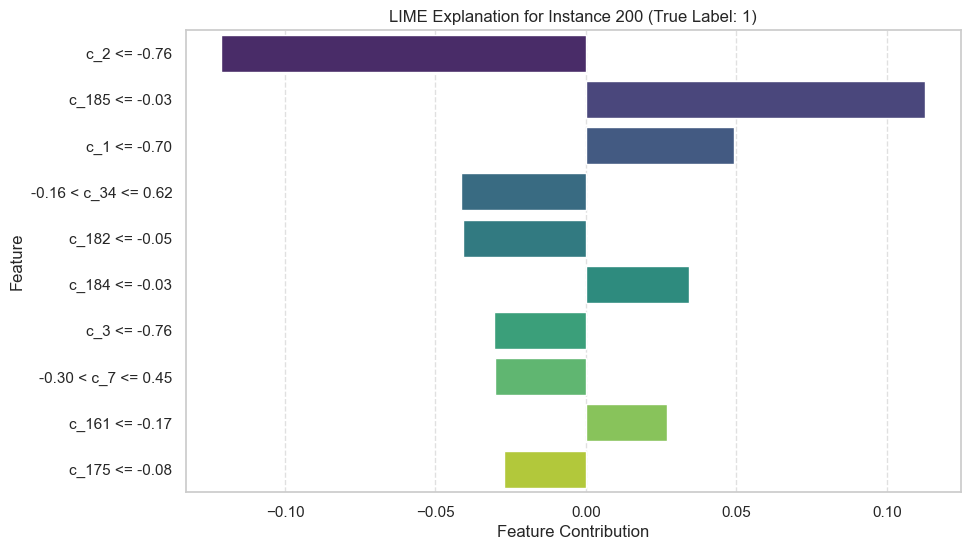

In [110]:
# Create a Lime Explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Features from the training data
    training_labels=np.array(y_train),  # Target labels for training data
    mode="classification",  # Set to 'classification' or 'regression' based on your task
    feature_names=X_train.columns,  # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification (modify if more classes)
    discretize_continuous=True  # Discretizes continuous features for better explanation
)

# Select a random instance from the test set
idx = 200  ################################  You can change this index to select a different instance! ##############################
instance = X_test.iloc[idx]  # The input instance

# Get the true label for the selected instance
true_label = y_test.iloc[idx]

print("True Label for selected instance:", true_label)
print("Instance features:\n", instance)

# Explain the instance using the LIME explainer
exp = explainer.explain_instance(
    data_row=instance,  # Instance to explain
    predict_fn=pipeline_model.predict_proba,  # Prediction function from the model
    num_features=10  # Number of features to include in the explanation
)

# Extract feature contributions from the explanation object
feature_importance = exp.as_list()  # Returns a list of (feature, contribution) tuples

# Convert the feature importance to a DataFrame for easy visualization
lime_df = pd.DataFrame(feature_importance, columns=['Feature', 'Contribution'])

# Plot the LIME explanation using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Contribution', 
    y='Feature', 
    data=lime_df, 
    palette='viridis', 
    orient='h'
)
plt.title(f'LIME Explanation for Instance {idx} (True Label: {true_label})')
plt.xlabel('Feature Contribution')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


### Interpretation:
Top Negative Contributor:

c_2 <= -0.76 has the strongest negative impact on the prediction, significantly pushing it down. This suggests that, in this instance, a lower value for c_2 is associated with a reduced prediction score.

Top Positive Contributor:

c_185 <= -0.03 has the strongest positive contribution to the prediction. This means that the value of c_185 increases the prediction probability for this instance.

Mixed Contributions:

Some features, such as c_34 and c_3, have smaller contributions but still affect the prediction. The direction and magnitude of these contributions depend on their values within specific ranges shown on the y-axis.